The audio used for test have similar characteristics of training data. So the performance are top. However there are not great variability across data. 

In [22]:
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import joblib
import librosa
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from pydub import AudioSegment
import tempfile
import os

In [23]:
# Suppress warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Load Dataset

In [24]:
# Load dataset
data_path = "C:/Users/sassi/Documents/DeepFakePhishing/Data/DATASET-balanced.csv"
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE


In [15]:
df.shape

(11778, 27)

We consider:
- **Chroma**: Captures the **energy distribution across the 12 pitch classes** (musical notes) and is useful for harmonic and tonal analysis.
    - If the harmonic content is important (ex. distinguish between real and shyntitized  voices based on timbre), keep all 12 values can be useful. If you want a global measure, you can reduce 12 to 1. If you're working with human voice, the notes variation could not be critical, sol reduce to only one value can be enough.
- **RMS (Root Mean Square Energy)**: Measures the **overall energy of the signal** over time.
- **Spectral Features**: describe how frequency energy is distributed
    - **Spectral Centroid**: Represents the "center of mass" of the spectrum, often perceived as the **brightness of the sound**.
    - **Spectral bandwidth**: Measures the spread of frequencies around the spectral centroid, related to **timbral richness**.
    - **Spectral rolloff**: The frequency below which a certain percentage of the total spectral energy is contained, used for distinguishing voiced from unvoiced sounds.
- **Zero Crossing Rate**: The rate at which the audio signal crosses the zero amplitude axis, useful for detecting **percussive or noisy sounds**.
- **MFCCs**: Represents the **short-term power spectrum of a sound**, commonly used in speech and audio recognition.
    - These 20 coefficients represent the "shape" of the spectral envelope after apply a transformation. They capture the various timbral and spectral characteristics of the sound that correspond to different frequencies.

# Data Descriptive Statistics

In [25]:
df_statistics = df.groupby('LABEL').agg(['mean', 'median', 'std'])
df_statistics

chroma_stft                           rms                      \
             mean    median       std      mean    median       std   
LABEL                                                                 
FAKE     0.432965  0.433403  0.067805  0.035882  0.031765  0.024369   
REAL     0.410885  0.401281  0.069209  0.039906  0.032006  0.031212   

      spectral_centroid                           spectral_bandwidth  ...  \
                   mean       median          std               mean  ...   
LABEL                                                                 ...   
FAKE        2897.060112  2762.580508   800.470375        3216.608515  ...   
REAL        2541.342634  2353.973017  1253.831561        2883.991462  ...   

         mfcc17    mfcc18                        mfcc19                      \
            std      mean    median       std      mean    median       std   
LABEL                                                                         
FAKE   4.653088 -1.381362 -1.806637  4.405327 -3.719798 -3.411422  5.286986   
REAL   4.529496 -4.852858 -4.052620  4.909374 -1.788270 -1.989946  4.398071   

         mfcc20                      
           mean    median       std  
LABEL                                
FAKE  -4.774704 -4.217693  4.586413  
REAL  -4.079989 -3.288947  6.226009  

[2 rows x 78 columns]

In [7]:
df_statistics.to_excel("stats.xlsx")

**Chromagram & Root Mean Square (RMS)**
- Both features show **very similar values** for Real and Fake, suggesting that they do not significantly differentiate between the two classes.
- The Root Mean Square (RMS), which represents the energy of the signal, has **low variation** (standard deviation ~0.02-0.03) in both categories.

**Spectral Features**
- **Spectral Centroid**: Fake has a higher mean value (2897.06 vs. 2541.34), indicating that **Fake sounds tend to have more high-frequency content**.

- **Spectral Bandwidth**: Fake also has a higher bandwidth (3216.61 vs. 2883.99), confirming the presence of a **broader frequency range in Fake sounds**.

- **Spectral Rolloff**: Fake signals show a higher rolloff point (5271.79 vs. 4683.44), meaning that their **energy is distributed more towards higher frequencies**.
 
- **Zero Crossing Rate (ZCR)**: Fake samples exhibit a higher ZCR (0.08 vs. 0.06), suggesting that **Fake sounds contain more rapid oscillations, which may indicate greater noise or higher pitch components**.

Fake signals contain more high-frequency components than Real signals, and they tend to be more consistent 

**MFCCs**
- **Low-Frequency Components (MFCC1 - MFCC5)**:
    - MFCC1 (Overall Energy): Fake has slightly lower energy (-388.48 vs. -376.65), with lower variation.
    - MFCC2 & MFCC3: Fake signals show lower values, meaning that their **low-frequency components are less pronounced compared to Real signals**.
- **Mid-Frequency Components (MFCC6 - MFCC10)**:
    - MFCC4 & MFCC6: Fake signals have significantly higher values, indicating differences in mid-frequency content.
    - MFCC9 & MFCC10: Fake samples show consistently higher values, reinforcing the idea that Fake sounds emphasize mid-to-high frequency components.
- **High-Frequency Components (MFCC11 - MFCC20)**:
    - Fake signals generally have **higher values** in MFCC11-20, suggesting a stronger presence of high-frequency elements.
    - MFCC18 shows a particularly notable difference (-4.85 in Real vs. -1.38 in Fake), indicating that **Fake sounds maintain more uniformity in the higher frequency ranges**.

 Fake sounds tend to have weaker low frequencies and stronger mid-to-high frequencies, making them timbrally distinct from Real sounds.

**Key Findings**
- Fake sounds emphasize higher frequencies
- Real sounds show greater variability
- MFCCs reveal strong differences in timbral structure, particularly in the mid-to-high frequency range

## Correlation

Let's see if MFCC coefficients play a crucial role to determine if an audio is fake or not

In [26]:
# Replace 'fake' with 1 and 'real' with 0 in the 'Label' column
df['LABEL'] = df['LABEL'].replace({'FAKE': 1, 'REAL': 0})

In [27]:
# Person correlation coefficients between Features and label
correlation_matrix = df.corr()
feature_label_corr = correlation_matrix['LABEL'].drop('LABEL')  # Drop 'Label' from its own correlation
print("Correlation between features and label:")
print(feature_label_corr)

Correlation between features and label:
chroma_stft           0.159104
rms                  -0.071681
spectral_centroid     0.166736
spectral_bandwidth    0.190672
rolloff               0.135560
zero_crossing_rate    0.156303
mfcc1                -0.074321
mfcc2                -0.364674
mfcc3                 0.176568
mfcc4                 0.295981
mfcc5                 0.000456
mfcc6                 0.278099
mfcc7                -0.076711
mfcc8                 0.143846
mfcc9                 0.244161
mfcc10                0.207447
mfcc11                0.133581
mfcc12                0.217934
mfcc13                0.079600
mfcc14               -0.082551
mfcc15                0.091300
mfcc16                0.115451
mfcc17               -0.049193
mfcc18                0.348803
mfcc19               -0.194811
mfcc20               -0.063403
Name: LABEL, dtype: float64


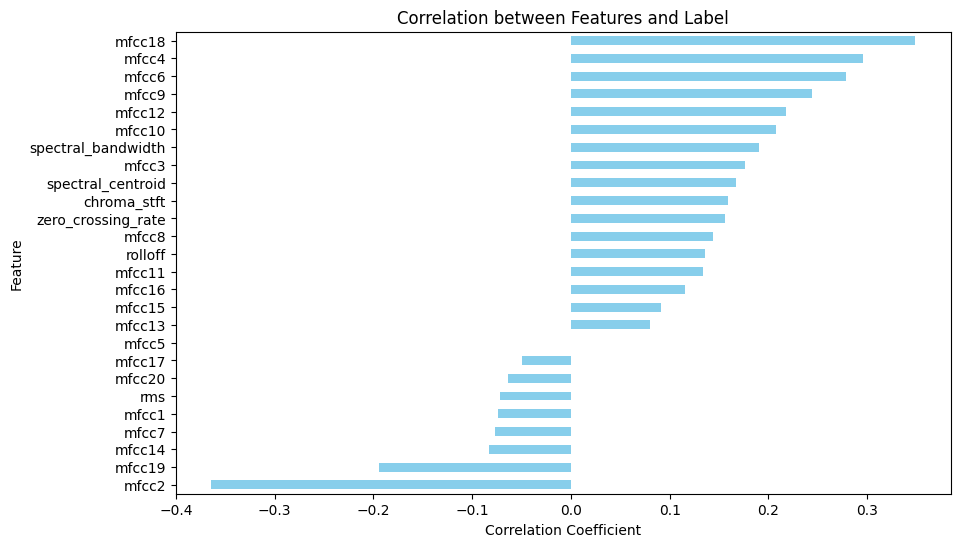

In [28]:
correlation_values = {
    'chroma_stft': 0.159104,
    'rms': -0.071681,
    'spectral_centroid': 0.166736,
    'spectral_bandwidth': 0.190672,
    'rolloff': 0.135560,
    'zero_crossing_rate': 0.156303,
    'mfcc1': -0.074321,
    'mfcc2': -0.364674,
    'mfcc3': 0.176568,
    'mfcc4': 0.295981,
    'mfcc5': 0.000456,
    'mfcc6': 0.278099,
    'mfcc7': -0.076711,
    'mfcc8': 0.143846,
    'mfcc9': 0.244161,
    'mfcc10': 0.207447,
    'mfcc11': 0.133581,
    'mfcc12': 0.217934,
    'mfcc13': 0.079600,
    'mfcc14': -0.082551,
    'mfcc15': 0.091300,
    'mfcc16': 0.115451,
    'mfcc17': -0.049193,
    'mfcc18': 0.348803,
    'mfcc19': -0.194811,
    'mfcc20': -0.063403
}

correlation_df = pd.Series(correlation_values)

# Plotting the correlations between features and label
plt.figure(figsize=(10, 6))
correlation_df.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation between Features and Label')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()

From the correlation results:
- Strongest **Positive** Correlation: **mfcc18** with a correlation of 0.348803.
- Strongest **Negative** Correlation: **mfcc2** with a correlation of -0.364674.
- **Near-zero Correlations**: Features like **mfcc5** with 0.000456 or **mfcc17** with -0.049193 have little to no correlation with the label.

Features with very low correlation with the label may not contribute much to predicting the target.

# Data Preprocessing

## Feature scaling

In [29]:
# Separate features and labels
X = df.drop('LABEL', axis=1)
y = df['LABEL']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
# test size = 0.5

# Models Training

## Random Forest

In [ ]:
# Hyperparameter Tuning using optuna

# Optuna objective function
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 400, step=50)
    max_depth = trial.suggest_int('max_depth', [None, 10, 20, 30, 40]) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Train Random Forest model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Evaluate model using cross-validation
    score = cross_val_score(clf, X_train, y_train, cv=7, scoring='accuracy').mean() #val = 
    
    return score  # Maximize accuracy

# Run Optuna optimization
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=50)

[I 2025-03-27 13:26:20,082] A new study created in memory with name: no-name-0768e480-2cf7-4563-a878-6cd44565683e
[I 2025-03-27 13:27:01,713] Trial 0 finished with value: 0.9732540861812778 and parameters: {'n_estimators': 350, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.9732540861812778.
[I 2025-03-27 13:27:11,746] Trial 1 finished with value: 0.9828061982593929 and parameters: {'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9828061982593929.
[I 2025-03-27 13:27:31,131] Trial 2 finished with value: 0.9731479516026321 and parameters: {'n_estimators': 150, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.9828061982593929.
[I 2025-03-27 13:27:59,432] Trial 3 finished with value: 0.9646571853109743 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min

In [33]:
# Display Best Hyperparameters and Best Cross-validation Score
print(f"Best Parameters for Random Forest: {study_rf.best_params}")
print(f"Best Cross-validation Score: {study_rf.best_value:.4f}")

Best Parameters for Random Forest: {'n_estimators': 150, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Cross-validation Score: 0.9868


In [ ]:
# Train the best Random Forest model
best_rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42)
best_rf_model.fit(X_train, y_train) #combhine train val = 80%

# Evaluate the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test)


Random Forest Results:
Accuracy: 0.9898
F1 Score: 0.9897
ROC AUC Score: 0.9898
Confusion Matrix:
[[1183   10]
 [  14 1149]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1193
           1       0.99      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



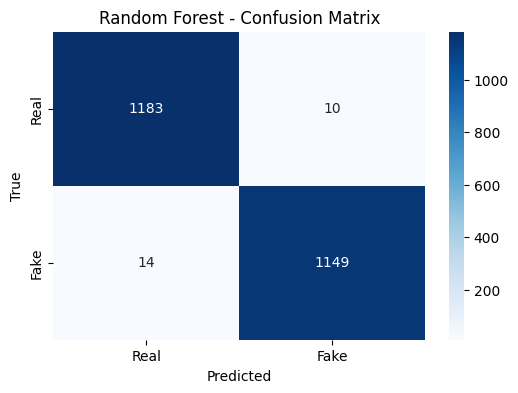

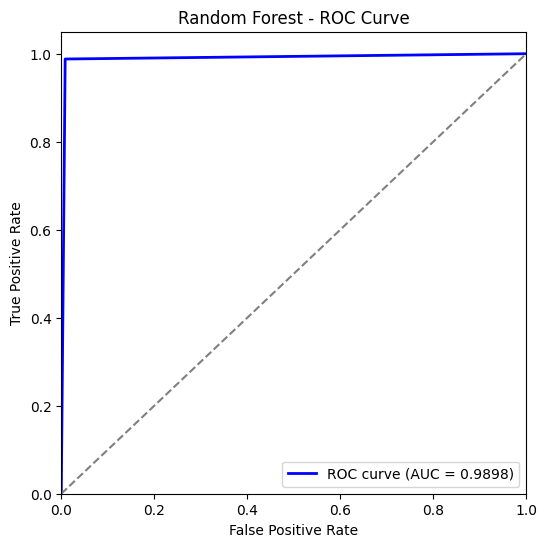

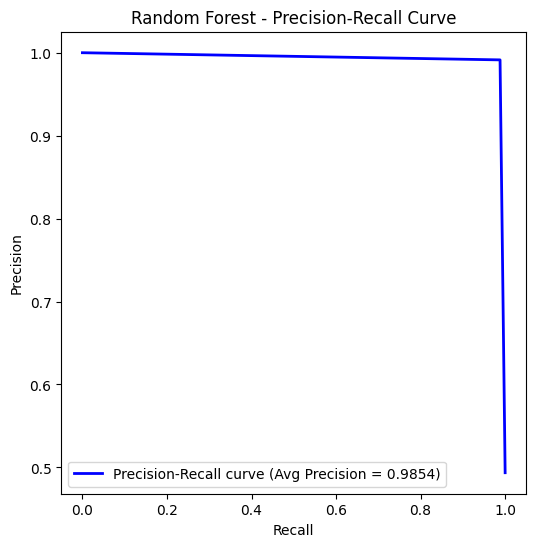

In [90]:
# Evaluate Random Forest model
evaluate_model(y_test, y_pred_rf, "Random Forest")

### How Fast?

In [116]:
average_time_rf = compare_inference_time(best_rf_model, X_test, num_samples=1000, random_indices=random_indices)
print(f"Average inference time for Random Forest model: {average_time_rf:.6f} ms")

Average inference time for Random Forest model: 11.920326 ms


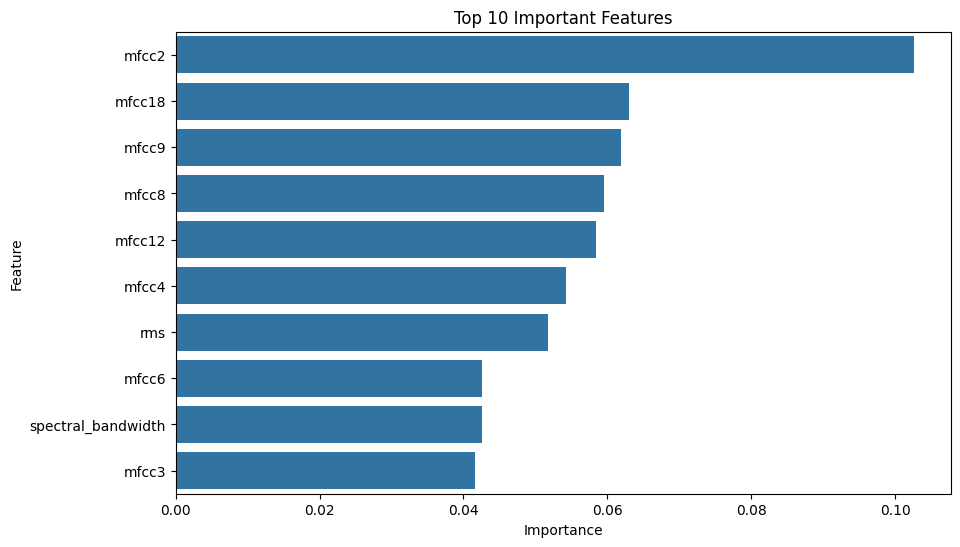

In [24]:
# Feature importance visualization
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Important Features')
plt.show()

Quando si utilizza l'attributo *features_importances* nei modelli ad alberi, il coefficiente rappresenta la riduzione normalizzata dell'impurezza (Gini) portata da ciascuna features. 
Per ogni feature viene calcolata la somma delle riduzioni dell'impurezza ottenuta in tutti i nodi in cui quella features viene usata per effettuare una divisione. Questi valori vengono normalizzati in modo che la somma totale delle importanze sia pare a 1.

Il 10% si riferisce alla riduzione totale dell'impurezza. Significa quindi che quella feature è responsabile del 10% della riduzione totale dell'impurezza. 
- Se la somma di tutte le feature importance e 100%, un valore di 0.10 ha contribuito per il 10% al processo decisionale del modello.

**NON** significa necessariamente che la feature ha un impatto diretto del 10% sulla predizione finale, ma che è stata frequentemente utilizzata per prendere decisioni all'interno degli alberi del modello

---

## XGBoost

In [ ]:
# Hyperparamter tuning

def objective(trial):
    param = {
        'objective': 'binary:logistic', 
        'eval_metric': 'logloss',        
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'use_label_encoder': False,
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train, cv=7, scoring='accuracy').mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2025-03-26 15:29:00,104] A new study created in memory with name: no-name-b43a3948-c7bc-485f-961f-7d7a5b058a9d
[I 2025-03-26 15:29:01,367] Trial 0 finished with value: 0.9785609375615965 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.04561849616744343, 'subsample': 0.94237037967809, 'colsample_bytree': 0.9621597022964121, 'gamma': 4.5513463270932215, 'min_child_weight': 6}. Best is trial 0 with value: 0.9785609375615965.
[I 2025-03-26 15:29:01,886] Trial 1 finished with value: 0.9111659261011337 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.010559937390155469, 'subsample': 0.983166593903186, 'colsample_bytree': 0.6460465323026672, 'gamma': 3.233078322770792, 'min_child_weight': 8}. Best is trial 0 with value: 0.9785609375615965.
[I 2025-03-26 15:29:04,755] Trial 2 finished with value: 0.9824874554393552 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.01860538050832428, 'subsample': 0.8810900018068635, 'co

In [94]:
print(f"Best Parameters: {study_xgb.best_params}")
print(f"Best Cross-Validation Score: {study_xgb.best_value:.4f}")

Best Parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.09091411626491555, 'subsample': 0.678731508044886, 'colsample_bytree': 0.8571294815096144, 'gamma': 0.1937930782466752, 'min_child_weight': 2}
Best Cross-Validation Score: 0.9918


In [95]:
# Train the best XGBoost Classifier
best_xgb_model = XGBClassifier(**study_xgb.best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Evaluate the XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)


XGBoost Results:
Accuracy: 0.9941
F1 Score: 0.9940
ROC AUC Score: 0.9941
Confusion Matrix:
[[1184    9]
 [   5 1158]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1193
           1       0.99      1.00      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



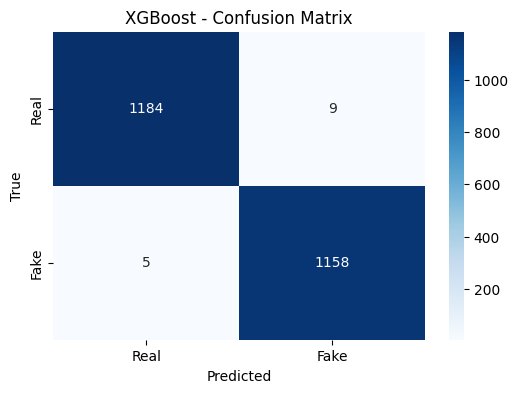

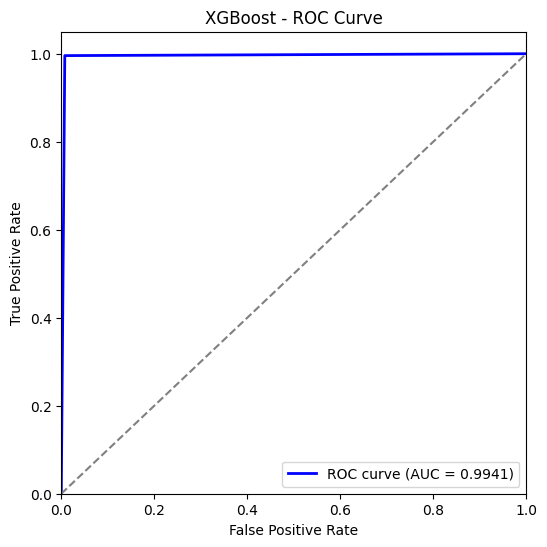

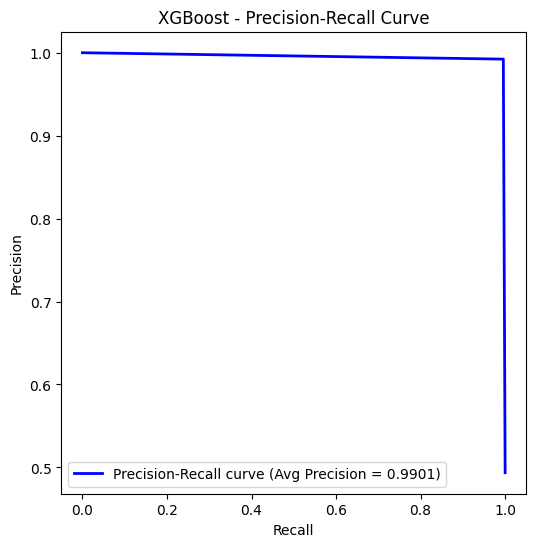

In [96]:
# Evaluate XGBoost model
evaluate_model(y_test, y_pred_xgb, "XGBoost")

### How fast?

In [118]:
# For another model, such as SVM, use the same `random_indices`
average_time_xgb = compare_inference_time(best_xgb_model, X_test, num_samples=1000, random_indices=random_indices)
print(f"Average inference time for XGBoost model: {average_time_xgb:.6f} ms")

Average inference time for XGBoost model: 0.449291 ms


---

## K-Nearest Neighbor

In [ ]:
# Hyperparameter tuning

def objective(trial):
    # Hyperparameters to tune
    n_neighbors = trial.suggest_int('n_neighbors', 3, 30) 
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])  
    p = trial.suggest_int('p', 1, 2) 
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    
    # KNN classifier with the suggested hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p,
        leaf_size=leaf_size
    )
    
    # Evaluate model using cross-validation
    score = cross_val_score(knn, X_train, y_train, cv=7, scoring='accuracy').mean()
    
    return score  

# Create an Optuna study
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective, n_trials=50) 

[I 2025-03-26 15:48:42,605] A new study created in memory with name: no-name-5c36144a-329a-462f-959c-4ba33a3c7376
[I 2025-03-26 15:48:42,761] Trial 0 finished with value: 0.9951178093822968 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'p': 2, 'leaf_size': 40}. Best is trial 0 with value: 0.9951178093822968.
[I 2025-03-26 15:48:42,893] Trial 1 finished with value: 0.9943748673317767 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2, 'leaf_size': 14}. Best is trial 0 with value: 0.9951178093822968.
[I 2025-03-26 15:48:43,976] Trial 2 finished with value: 0.9945871364890682 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 2, 'leaf_size': 33}. Best is trial 0 with value: 0.9951178093822968.
[I 2025-03-26 15:48:45,156] Trial 3 finished with value: 0.9937380598599024 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 1, 'leaf_size': 18}. Best is 

In [104]:
print(f"Best Parameters: {study_knn.best_params}")
print(f"Best Cross-Validation Score: {study_knn.best_value:.4f}")

Best Parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'p': 2, 'leaf_size': 40}
Best Cross-Validation Score: 0.9951


In [ ]:
# Train the best KNN Classifier
best_knn_model = KNeighborsClassifier(**study_knn.best_params)
best_knn_model.fit(X_train, y_train)

# Evaluate the KNN model
y_pred_knn = best_knn_model.predict(X_test)


K-Nearest Neighbor Results:
Accuracy: 0.9941
F1 Score: 0.9940
ROC AUC Score: 0.9941
Confusion Matrix:
[[1184    9]
 [   5 1158]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1193
           1       0.99      1.00      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



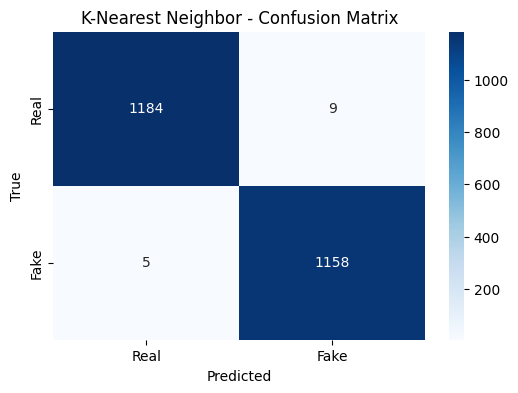

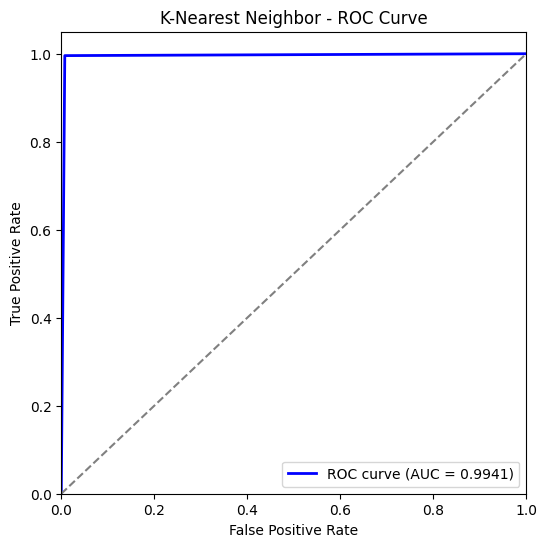

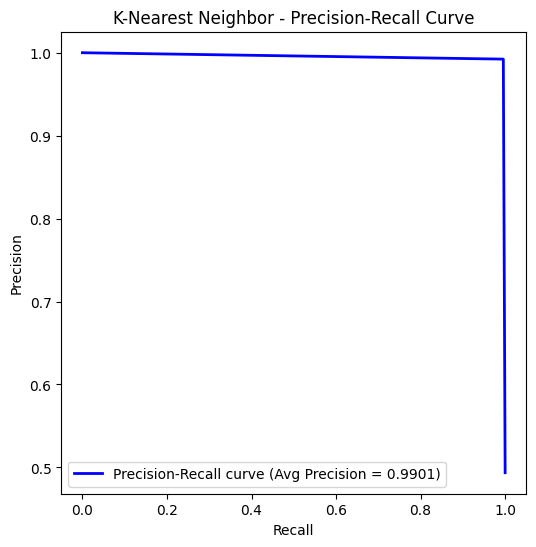

In [ ]:
# Evaluate KNN model
evaluate_model(y_test, y_pred_knn, "K-Nearest Neighbor")

### How fast?

In [117]:
# For another model, such as SVM, use the same `random_indices`
average_time_knn = compare_inference_time(best_knn_model, X_test, num_samples=1000, random_indices=random_indices)
print(f"Average inference time for KNN model: {average_time_knn:.6f} ms")

Average inference time for KNN model: 5.375785 ms


---

## Support Vector Machine

In [ ]:
# Hyperparameter tuning

def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-3, 1e3) # range from 0.001 to 1000
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])  #
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3 
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e2) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'  
    coef0 = trial.suggest_uniform('coef0', 0.0, 1.0) if kernel in ['poly', 'sigmoid'] else 0.0 
    
    # KNN classifier with the suggested hyperparameters
    svc = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        coef0=coef0,
        random_state=42
    )
    
    # Evaluate model using cross-validation
    score = cross_val_score(svc, X_train, y_train, cv=7, scoring='accuracy').mean()
    
    return score  

# Create an Optuna study
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=50)  

[I 2025-03-26 15:56:10,051] A new study created in memory with name: no-name-ecbb4353-7e34-4a61-8506-c7a936de30dc
[I 2025-03-26 15:56:22,744] Trial 0 finished with value: 0.5015920186796858 and parameters: {'C': 1.7091937049612025, 'kernel': 'poly', 'degree': 5, 'gamma': 0.0002793396871091456, 'coef0': 0.07626796314939777}. Best is trial 0 with value: 0.5015920186796858.
[I 2025-03-26 15:56:31,403] Trial 1 finished with value: 0.8712587561027385 and parameters: {'C': 0.04325660503301502, 'kernel': 'poly', 'degree': 2, 'gamma': 0.005547342574842204, 'coef0': 0.25941422388111557}. Best is trial 1 with value: 0.8712587561027385.
[I 2025-03-26 15:56:47,737] Trial 2 finished with value: 0.5015920186796858 and parameters: {'C': 0.0019551783071092834, 'kernel': 'rbf', 'gamma': 0.00022941733047538262}. Best is trial 1 with value: 0.8712587561027385.
[I 2025-03-26 15:56:58,764] Trial 3 finished with value: 0.5015920186796858 and parameters: {'C': 156.50712138843, 'kernel': 'poly', 'degree': 4, 

KeyboardInterrupt: 

In [ ]:
print(f"Best Parameters: {study_svm.best_params}")
print(f"Best Cross-Validation Score: {study_svm.best_value:.4f}")

Best Parameters: {'C': 12.76543961283874, 'kernel': 'linear'}
Best Cross-Validation Score: 0.9069


In [ ]:
# Train the best SVM Classifier
best_svm_model = KNeighborsClassifier(**study_svm.best_params)
best_svm_model.fit(X_train, y_train)

# Evaluate the SVM model
y_pred_svm = best_svm_model.predict(X_test)

TypeError: __init__() got an unexpected keyword argument 'C'

In [ ]:
# Evaluate SVM model
evaluate_model(y_test, y_pred_svm, "Support Vector Machine")

### How Fast?

In [ ]:
# For another model, such as SVM, use the same `random_indices`
average_time_svm = compare_inference_time(best_svm_model, X_test, num_samples=1000, random_indices=random_indices)
print(f"Average inference time for SVM model: {average_time_svm:.6f} ms")

---

# Models Saving

In [119]:
joblib.dump(best_rf_model, "best_random_forest_model.pkl") # best random forest
joblib.dump(best_xgb_model, "best_xgboost_model.pkl")

joblib.dump(scaler, "scaler.pkl")  # save the scaler


print("Models and scaler saved successfully!")

Models and scaler saved successfully!


# Testing on new audio

In [164]:
# Load the models and scaler
rf_model = joblib.load("best_random_forest_model.pkl")  # Load the best Random Forest model
xgb_model = joblib.load("best_xgboost_model.pkl")  
scaler = joblib.load("scaler.pkl")  # Load the saved scaler

In [130]:
# Function to take 1 seconds of audio
def truncated_audio(file_audio):

    audio = AudioSegment.from_file(file_audio)
    
    truncated_audio = audio[:1000]
    
    return truncated_audio

In [165]:
# Function to extract features from the audio file (same as used in training)
def extract_features(truncated_audio_data):

    # Save the AudioSegment to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as temp_file:
        temp_filename = temp_file.name
        truncated_audio_data.export(temp_filename, format="wav")  # Export the audio to the temporary file

    # Load the audio file
    y, sr = librosa.load(temp_filename, sr=None)
    
    # Extract features
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    rms = np.mean(librosa.feature.rms(y=y))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)  # MFCCs from 1st to 20th
    
    # Remove temporary file after usage
    os.remove(temp_filename)

    # Create a dictionary of features
    feature_dict = {
        'chroma_stft': chroma_stft,
        'rms': rms,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'rolloff': rolloff,
        'zero_crossing_rate': zero_crossing_rate,
    }
    
    # Add the MFCCs to the feature dictionary (20 MFCCs)
    for i in range(20):
        feature_dict[f'mfcc{i+1}'] = mfcc[i]
    
    return feature_dict

## Predict on single file

In [166]:
# Example usage: Test on a new audio file
def test_model_on_new_audio(audio_path):

    truncated_audio_data = truncated_audio(audio_path)

    # Extract features from the new audio file
    features = extract_features(truncated_audio_data)
    
    # Convert the feature dictionary to a pandas DataFrame
    feature_df = pd.DataFrame([features])
    
    # Scale the features using the saved scaler
    scaled_features = scaler.transform(feature_df)

    # Predict using Random Forest model
    rf_pred = rf_model.predict(scaled_features)
    rf_prob = rf_model.predict_proba(scaled_features)[:, 1]  # Probability of being FAKE 

    # Predict using XGBoost model
    xgb_pred = xgb_model.predict(scaled_features)

    xgb_prob = xgb_model.predict_proba(scaled_features)[:, 1]  # Probability of being FAKE

    # Print the results
    print(f"Random Forest Prediction: {'FAKE' if rf_pred[0] == 1 else 'REAL'}")
    print(f"XGBoost Prediction: {'FAKE' if xgb_pred[0] == 1 else 'REAL'}")
    
    print(f"Random Forest Probability of FAKE: {rf_prob[0]:.4f}")
    print(f"XGBoost Probability of FAKE: {xgb_prob[0]:.4f}")

In [169]:
# Example audio file path
audio_file_path = "C:/Users/sassi/Documents/DeepFakePhishing/Data/for-new/fake/Obama-to-Trump.wav"

# Test the models on the new audio
test_model_on_new_audio(audio_file_path)

Random Forest Prediction: REAL
XGBoost Prediction: REAL
Random Forest Probability of FAKE: 0.2057
XGBoost Probability of FAKE: 0.0123


# Functions

In [76]:
# Function to print and evaluate performance metrics
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (Avg Precision = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

In [115]:
# Compare the inference time of a given model on the same random test samples.
def compare_inference_time(model, X_test, num_samples=1000, random_indices=None, random_seed=42):
    """
    Parameters:
    - model: The model to evaluate (e.g., RandomForest, SVM, KNN, etc.).
    - X_test: The test set to evaluate the model on.
    - num_samples: Number of random samples to test (default is 1000).
    - random_indices: Optionally, specific random indices for testing. If None, it will pick random samples.
    - random_seed: The random seed to ensure consistent sample selection across different models (default is 42).
    
    Returns:
    - average_inference_time: The average inference time (in milliseconds) over the chosen samples.
    """
    # If random indices are not provided, select them randomly from the test set
    if random_indices is None:
        np.random.seed(random_seed)  # Set seed for reproducibility
        random_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    # Store total inference time
    total_time = 0.0

    for idx in random_indices:
        single_sample = np.expand_dims(X_test[idx], axis=0)  # Add batch dimension
        
        start_time = time.time()
        y_pred = model.predict(single_sample)  # Make prediction
        end_time = time.time()

        total_time += (end_time - start_time)

    # Compute average inference time (ms)
    average_inference_time = (total_time / num_samples) * 1000  # Convert to milliseconds

    return average_inference_time

# generate random indices once, using a fixed seed, ensuring sample is the same for each model
random_indices = np.random.choice(len(X_test), 1000, replace=False)